Topic analysis

Now lets analyse a bit the main topics of our data set


Imports

In [26]:
%store -r game_df_cleaned
%store -r swords_df_cleaned

%store -r game_text_cleaned
%store -r swords_text_cleaned

In [27]:
# !pip install textacy
# !python -m spacy download en_core_web_lg
# !pip install seaborn

In [28]:
import pandas as pd
import spacy
import matplotlib.pyplot as plt
from collections import Counter #for counting
import seaborn as sns #for visualization
from IPython.display import Markdown, display
from siuba import *

plt.style.use('seaborn')
sns.set(font_scale=2)
nlp = spacy.load('en_core_web_lg')
nlp.max_length = 5000000

In [29]:
def text_cleaned_to_string(text: list) -> str:
    res = ""
    for l_ in text:
        for word in l_:
            res += word + " "
    return res

In [30]:

def analyze_topics(text: list):
    text_string = text_cleaned_to_string(text)
    doc = nlp(text_string)

    topics = []
    for token in doc:
        if (not token.is_stop) and (token.pos_ == "NOUN") and (len(str(token))>2):
            topics.append(token)

    topics = [str(x) for x in topics]

    df_nouns = pd.DataFrame(topics, columns=["Topics"])
    df_nouns
    plt.figure(figsize=(7,6))
    sns.countplot(y="Topics",
                 data=df_nouns,
                 order=df_nouns["Topics"].value_counts().iloc[:15].index)
    plt.show()

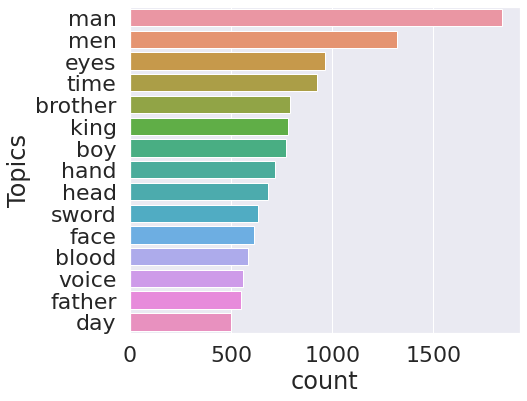

In [31]:
analyze_topics(game_text_cleaned)

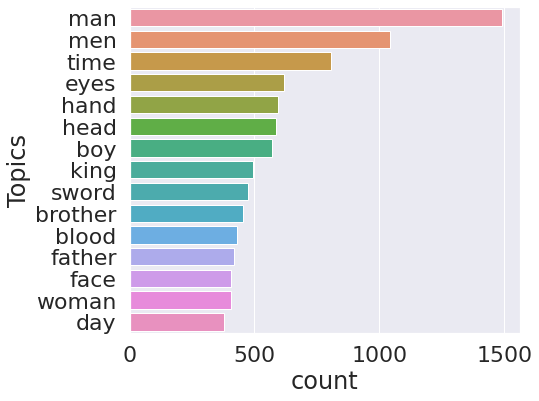

In [32]:
analyze_topics(swords_text_cleaned)

In [33]:
def get_characters(text: list):
    text_string = text_cleaned_to_string(text)
    doc = nlp(text_string)

    characters = []
    for ent in doc.ents:
        if ent.label_ in ["PERSON"]:
            characters.append(ent.text.strip())

#     characters = [str(x) for x in characters]

    df_nouns = pd.DataFrame(characters, columns=["Main Characters"])
    df_nouns = df_nouns[~df_nouns["Main Characters"].str.contains(']')]
    return df_nouns

def get_character_string(text: list):
    characters = get_characters(text)
    character_list = []
    for x in characters['Main Characters']:
        character_list.append(x)

    df = pd.DataFrame(character_list, columns=["Characters"])
    return  df

def main_characters(text: list):

    df_nouns = get_characters(text)
    plt.figure(figsize=(7,6))
    sns.countplot(y="Main Characters",
                 data=df_nouns,
                 order=df_nouns["Main Characters"].value_counts().iloc[:10].index)
    plt.show()

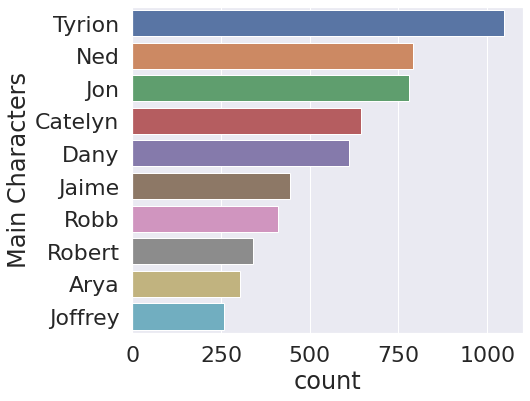

In [34]:
main_characters(game_text_cleaned)

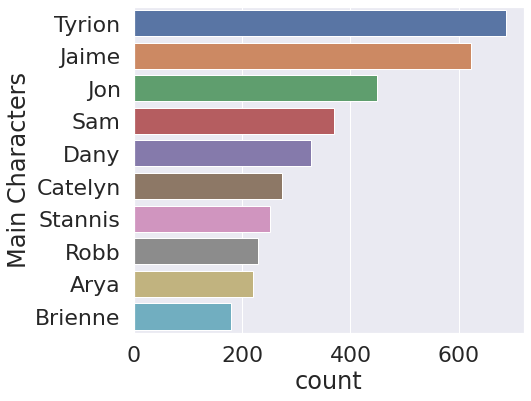

In [35]:
main_characters(swords_text_cleaned)

In [36]:
def time_analysis(text: list):
    text_string = text_cleaned_to_string(text)
    doc = nlp(text_string)

    time = []
    for ent in doc.ents:
        if ent.label_ in ["DATE"]:
            time.append(ent.text.strip())

    time = [str(x) for x in time]

    df_nouns = pd.DataFrame(time, columns=["Time"])
    plt.figure(figsize=(7,6))
    sns.countplot(y="Time",
                 data=df_nouns,
                 order=df_nouns["Time"].value_counts().iloc[:15].index)
    plt.show()

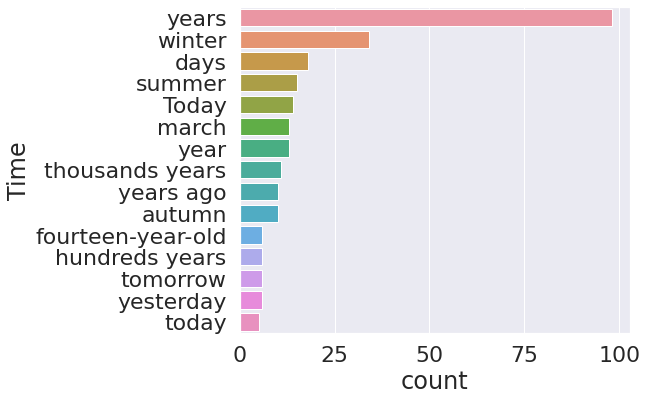

In [37]:
time_analysis(game_text_cleaned)

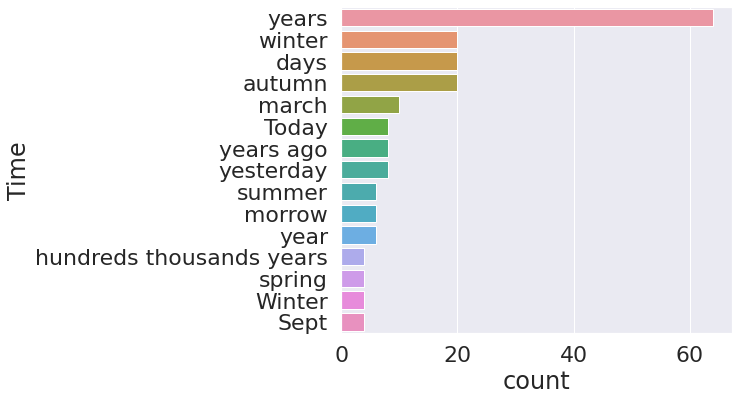

In [38]:
time_analysis(swords_text_cleaned)

In [89]:
def characters_deaths(characters : pd.DataFrame, text : list) -> pd.DataFrame:
    
    text_string = text_cleaned_to_string(text)
    to_search = pd.DataFrame({
        "word" : text_string.split()
    })
    # we build a dataframe containing the characters and a flag(default=False) which will be True later if the character died
    deaths = characters.assign(dead = 'False')
    deaths = deaths.drop_duplicates(subset=['Characters'], ignore_index=True)

    flags = ['dead', 'died', 'killed', 'murdered', 'stabbed ', 'cut off', 'poisoned', 'hanged']
    last_character = ""
    for word in to_search['word']:
        for x in deaths['Characters']:
            if x == word:
                last_character = x
                break
        if word in flags and last_character != "":
            deaths.loc[deaths['Characters'] == last_character, 'dead']= 'True'

    return deaths



In [92]:
chars_game = get_character_string(game_text_cleaned)
chars_game_filtered = count(chars_game, _.Characters, ascending=False)
chars_game_filtered = chars_game_filtered.sort_values(by='n', ascending=False)
chars_game_filtered.drop(columns='ascending')

chars_swords = get_character_string(swords_text_cleaned)
chars_swords_filtered = count(chars_swords, _.Characters, ascending=False)
chars_swords_filtered = chars_swords_filtered.sort_values(by='n', ascending=False)
chars_swords_filtered.drop(columns='ascending')

,Characters,n
2099,Tyrion,686
855,Jaime,622
964,Jon,448
1772,Sam,370
398,Dany,328
...,...,...
888,Jaime Urswyck,2
887,Jaime Tywin,2
885,Jaime Toss Loras,2
884,Jaime Swann,2


In [97]:
chars_swords_filtered.head(50)

,Characters,ascending,n
2099,Tyrion,False,686
855,Jaime,False,622
964,Jon,False,448
1772,Sam,False,370
398,Dany,False,328
294,Catelyn,False,274
1919,Stannis,False,252
1630,Robb,False,230
85,Arya,False,220
235,Brienne,False,180


In [98]:
chars_game_filtered.head(50)

,Characters,ascending,n
3209,Tyrion,False,1049
2088,Ned,False,791
1380,Jon,False,780
440,Catelyn,False,645
608,Dany,False,612
1239,Jaime,False,445
2477,Robb,False,411
2540,Robert,False,341
124,Arya,False,304
1356,Joffrey,False,259


In [91]:
# print(my_characters_filtered[:50])
dead_df = characters_deaths(my_characters_filtered[:50], game_text_cleaned)
dead_df

,Characters,ascending,n,dead
0,Tyrion,False,1049,True
1,Ned,False,791,True
2,Jon,False,780,True
3,Catelyn,False,645,True
4,Dany,False,612,True
5,Jaime,False,445,True
6,Robb,False,411,True
7,Robert,False,341,True
8,Arya,False,304,True
9,Joffrey,False,259,True


In [46]:
dead_df[dead_df['dead'] == 'True']

,Characters,dead
